# Training in Brax

In [Brax Environments](https://colab.research.google.com/github/google/brax/blob/main/notebooks/environments.ipynb) we learned about creating environments and using them to quickly generate rollouts. We can learn all kinds of fun and useful behaviors on those environments via Brax's built-in training algorithms.

Let's try them out!

In [ ]:
#@title Install Brax and some helper modules
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os

from IPython.display import HTML, clear_output

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
  import brax
except ImportError:
  !pip install git+https://github.com/google/brax.git@main
  clear_output()
  import brax

from brax import envs
from brax import jumpy as jp
from brax.io import html
from brax.io import model
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

if 'COLAB_TPU_ADDR' in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()

First let's pick an environment to train an agent:

In [ ]:
#@title Preview a Brax environment { run: "auto" }
#@markdown Select the environment to train:

env_name = "ant"  # @param ['ant', 'fetch', 'grasp', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'pusher', 'reacher', 'walker2d', 'grasp', 'ur5e']
env = envs.get_environment(env_name=env_name)
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/agents/es/train.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/agents/apg/train.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/agents/ars/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

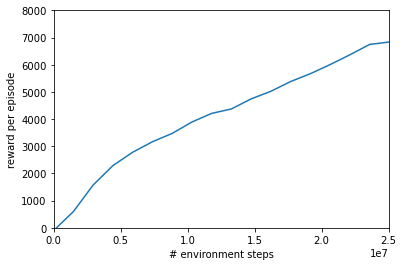

time to jit: 0:00:36.048989
time to train: 0:01:17.987978


In [ ]:
#@title Training some pre-included Brax environments

# We determined some reasonable hyperparameters offline and share them here.
train_fn = {
  # OpenAI gym environments:
  'ant': functools.partial(ppo.train, num_timesteps=25000000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024),
  'halfcheetah': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=512),
  'hopper': functools.partial(sac.train, num_timesteps=6_553_600, num_evals=20, reward_scaling=30, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=512, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192),
  'humanoid': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1),
  'humanoidstandup': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=15, num_minibatches=32, num_updates_per_batch=8, discounting=0.97, learning_rate=6e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024),
  'pusher': functools.partial(ppo.train, num_timesteps=50_000_000, num_evals=20, reward_scaling=5, episode_length=100, normalize_observations=True, action_repeat=1, unroll_length=30, num_minibatches=16, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4,entropy_cost=1e-2, num_envs=2048, batch_size=512),
  'reacher': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=4, unroll_length=50, num_minibatches=32, num_updates_per_batch=8, discounting=0.95, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=256, max_devices_per_host=8, seed=1),
  'walker2d': functools.partial(sac.train, num_timesteps=7_864_320, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.997, learning_rate=6e-4, num_envs=128, batch_size=128, grad_updates_per_step=32, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192, seed=1),
  # some other environments:
  'fetch': functools.partial(ppo.train, num_timesteps=100_000_000, num_evals=20, reward_scaling=5, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=4, discounting=0.997, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=256),
  'grasp': functools.partial(ppo.train, num_timesteps=600_000_000, num_evals=10, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=20, num_minibatches=32, num_updates_per_batch=2, discounting=0.99, learning_rate=3e-4, entropy_cost=0.001, num_envs=2048, batch_size=256),
  'ur5e': functools.partial(ppo.train, num_timesteps=20_000_000, num_evals=20, reward_scaling=10, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=5, num_minibatches=32, num_updates_per_batch=4, discounting=0.95, learning_rate=2e-4, entropy_cost=1e-2, num_envs=2048, batch_size=1024, max_devices_per_host=8),
}[env_name]

max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500, 'humanoid': 13000, 'humanoidstandup': 75_000, 'reacher': 5, 'walker2d': 5000, 'fetch': 15, 'grasp': 100, 'ur5e': 10, 'pusher': 0}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, _ = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [ ]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)

# Visualizing a Policy's Behavior

We can use the policy to generate a rollout for visualization:

In [ ]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=0)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

HTML(html.render(env.sys, [s.qp for s in rollout]))

ವಿದಾಯ! 👋